## Milestone 4 - Random Forest and XG Boost

#### Dependencies to install

In [3]:
!pip install ucimlrepo -q

#### Imports

In [21]:
# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset Loader
from ucimlrepo import fetch_ucirepo

# Modeling & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier as Dtree
from xgboost import XGBClassifier

# Imbalanced Data Handling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


#### Fetching data

In [5]:
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

####Preprocessing (Dropping duplicates)


In [6]:
dataset = pd.concat([X, y], axis=1)
print(dataset.isnull().sum(),'\n')
print('Number of duplicates:', dataset.duplicated().sum())

HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
Diabetes_binary         0
dtype: int64 

Number of duplicates: 24206


In [7]:
dataset = dataset.drop_duplicates()

X = dataset[X.columns]
y = dataset[y.columns]

#### Total observations in dataset

In [8]:
print('Number of rows in features dataset:', len(X))
print('Number of rows in target dataset:', len(y))

Number of rows in features dataset: 229474
Number of rows in target dataset: 229474


# Random Forest Classifier

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7427356237689344

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.75      0.83     48595
           1       0.34      0.71      0.46      8774

    accuracy                           0.74     57369
   macro avg       0.64      0.73      0.65     57369
weighted avg       0.84      0.74      0.77     57369



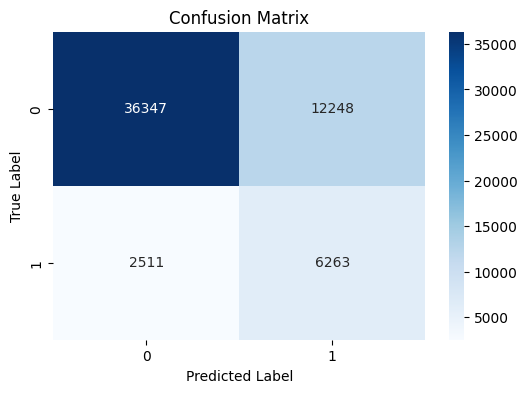


Top 20 Important Features:

                 feature  importance
0                 HighBP    0.187097
1                    BMI    0.134281
2               HighChol    0.091595
3              GenHlth_1    0.064221
4               DiffWalk    0.054483
5              GenHlth_2    0.048928
6              GenHlth_4    0.041959
7   HeartDiseaseorAttack    0.036052
8               PhysHlth    0.035959
9               MentHlth    0.023992
10             GenHlth_3    0.022402
11             GenHlth_5    0.017377
12              Income_8    0.012348
13     HvyAlcoholConsump    0.012344
14             CholCheck    0.011931
15                   Sex    0.011835
16          PhysActivity    0.010660
17                 Age_3    0.010381
18                Age_11    0.009739
19                Age_10    0.009206


In [16]:
# Choose which columns are categorical vs numeric/binary
categorical_cols = ["GenHlth", "Age", "Education", "Income"]
numeric_cols = []

for col in X.columns:
    if col not in categorical_cols:
        numeric_cols.append(col)

# Define preprocessing (OHE for categorical, keep numeric as is)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# Build Random Forest pipeline
rf_clf = Pipeline(
    steps=[
        ("prep", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=400,
            max_depth=14,
            class_weight="balanced",
            random_state=60
        ))
    ]
)

# Train the model
rf_clf.fit(X_train, y_train)

# Predict on test data
y_pred = rf_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# ============================
# Confusion Matrix
# ============================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ============================
# Feature Importance
# ============================

# Get the fitted preprocessor
preprocessor = rf_clf.named_steps["prep"]

# Get the OneHotEncoder from the preprocessor
cat_transformer = preprocessor.named_transformers_["cat"]

# Get names for the one-hot encoded categorical features
cat_feature_names = cat_transformer.get_feature_names_out(categorical_cols)

# Combine categorical + numeric feature names into a single list
all_features = list(cat_feature_names) + numeric_cols

# Get feature importance values from the trained Random Forest model
rf_model = rf_clf.named_steps["model"]
importances = rf_model.feature_importances_

# Put them into a DataFrame
rf_importance_df = pd.DataFrame({
    "feature": all_features,
    "importance": importances
})

# Sort by importance
rf_importance_df = rf_importance_df.sort_values(
    by="importance",
    ascending=False
).reset_index(drop=True)

print("\nTop 20 Important Features:\n")
print(rf_importance_df.head(20))

1. The model achieved 74% overall accuracy, showing good general performance across the dataset without any balancing or threshold adjustments.

2. Class 1 (diabetes) performance: precision = 0.34, recall = 0.71, f1 = 0.46, meaning the model detects 71% of diabetics while keeping false positives moderate.

3. Class 0 (non-diabetic) performance remains strong with precision = 0.94 and recall = 0.75, showing the model is very reliable at identifying non-diabetics.

4. Feature importance shows HighBP, BMI, HighChol, GenHlth, DiffWalk, and PhysHlth as the top drivers of predictions, indicating lifestyle and health-risk factors dominate the model's decision path.

5. Next Steps: Improve minority-class F1 by applying custom class weights, SMOTE oversampling, and threshold tuning.

# RF with Fine Turning
#### custom class weights and threshold for y_prob = 0.4

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy (threshold=0.4): 0.7292788788370026

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.73      0.82     48595
           1       0.33      0.74      0.46      8774

    accuracy                           0.73     57369
   macro avg       0.63      0.73      0.64     57369
weighted avg       0.85      0.73      0.76     57369



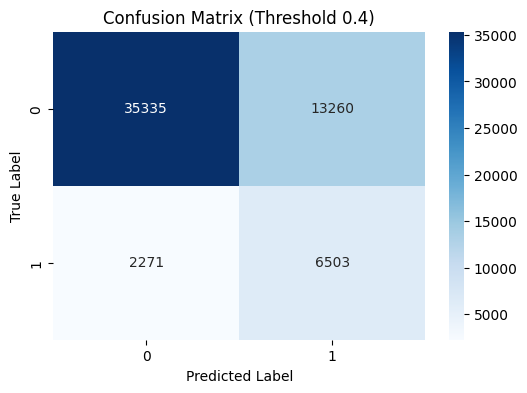

In [10]:
# -----------------------------
# Train Random Forest (custom class weights)
# -----------------------------

rf_clf = Pipeline(
    steps=[
        ("prep", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=300,
            max_depth=15,
            class_weight={0: 1, 1: 4},   # <-- custom weights
            random_state=42
        ))
    ]
)

# Fit the model
rf_clf.fit(X_train, y_train)

# -----------------------------
# Predict using THRESHOLD = 0.40
# -----------------------------

# Get probabilities for class 1
y_prob = rf_clf.predict_proba(X_test)[:, 1]

# Apply custom threshold
threshold = 0.40
y_pred_thresh = (y_prob >= threshold).astype(int)

# -----------------------------
# Evaluate
# -----------------------------
print(f"Accuracy (threshold={threshold}):", accuracy_score(y_test, y_pred_thresh))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_thresh))

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred_thresh)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Threshold {threshold})")
plt.show()


1. Applying custom class weights and a 0.40 threshold makes Random Forest much more sensitive to detecting diabetes, boosting minority recall to 74% while maintaining solid overall accuracy (73%).

2. Class 1 precision is 0.33, which is expected because the model now predicts more positives to reduce false negatives—crucial in medical screening tasks.

3. This configuration improves minority detection without heavily sacrificing performance and can be further enhanced by applying SMOTE oversampling or tuning thresholds to balance precision and recall.

# XGBoost

scale_pos_weight: 5.538198533601793
Accuracy: 0.7174606494796841

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.71      0.81     48595
           1       0.32      0.77      0.45      8774

    accuracy                           0.72     57369
   macro avg       0.63      0.74      0.63     57369
weighted avg       0.85      0.72      0.76     57369



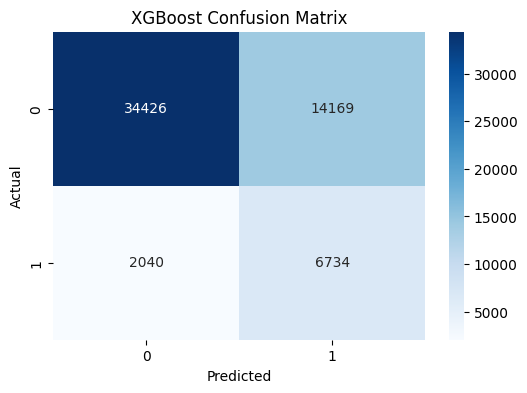

In [19]:
# After train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=50,
    stratify=y
)

# Calculate imbalance ratio
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

# XGBoost pipeline
xgb_clf = Pipeline(
    steps=[
        ("prep", preprocess),
        ("model", XGBClassifier(
            n_estimators=400,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            scale_pos_weight=scale_pos_weight,
            random_state=42
        ))
    ]
)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Train model
xgb_clf.fit(X_train, y_train)

# Predict
y_pred = xgb_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

1. XGBoost with scale_pos_weight ≈ 5.54 handled the dataset imbalance effectively and achieved strong minority recall (0.77) without oversampling.

2. The model produced 0.72 overall accuracy, with a particularly high precision for class 0 (0.94) and respectable F1 score for the minority class (0.45).

3. For diabetes detection (class 1), XGBoost showed significantly better recall than Random Forest, identifying most positive cases while keeping false negatives low.

4. Precision for class 1 (0.32) remained limited due to the heavy skew in the data, which is expected when the classifier becomes more sensitive to detecting positives.

5. Next Steps: Improve minority-class F1 by adding SMOTE oversampling during training and then applying threshold tuning (0.35–0.50) to balance recall and precision more effectively.

# XG Boost +SMOTE+Threshold Turning

Before SMOTE: [145782  26323]
After SMOTE : [145782 145782]
Accuracy with threshold=0.4: 0.640938485941885

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.61      0.74     48595
           1       0.27      0.78      0.40      8774

    accuracy                           0.64     57369
   macro avg       0.60      0.70      0.57     57369
weighted avg       0.84      0.64      0.69     57369



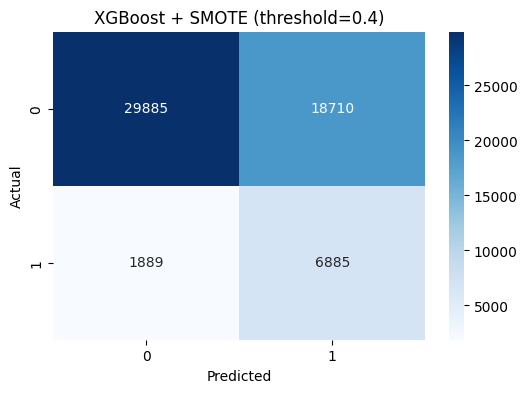

In [22]:

# ------------------------------------
# Train-test split
# ------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=50
)


# ------------------------------------
# Apply SMOTE on training data only
# ------------------------------------
sm = SMOTE(random_state=50)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE :", np.bincount(y_train_res))


# ------------------------------------
# XGBoost with imbalance handling
# ------------------------------------
neg = (y_train_res == 0).sum()
pos = (y_train_res == 1).sum()
scale_pos_weight = neg / pos

xgb_model = Pipeline(
    steps=[
        ("prep", preprocess),
        ("model", XGBClassifier(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="binary:logistic",
            eval_metric="logloss",
            scale_pos_weight=scale_pos_weight,
            tree_method="hist",
            random_state=50
        ))
    ]
)

# Train XGBoost
xgb_model.fit(X_train_res, y_train_res)


# ------------------------------------
# Predict with threshold tuning
# ------------------------------------
y_prob = xgb_model.predict_proba(X_test)[:, 1]
threshold = 0.40
y_pred = (y_prob >= threshold).astype(int)

print(f"Accuracy with threshold={threshold}: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


# ------------------------------------
# Confusion Matrix
# ------------------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"XGBoost + SMOTE (threshold={threshold})")
plt.show()


1. Applied SMOTE oversampling to balance the dataset, increasing minority samples
from 26K → 145K, making class 1 equally represented during training.

2. Trained an XGBoost classifier, which is highly effective for imbalanced datasets due to its boosting structure and weighted error correction.

3. Used scale_pos_weight to further adjust for imbalance, ensuring XGBoost treats class 1 (diabetic) as more important during training.

4. Lowered the prediction threshold from 0.50 → 0.40, making the model more sensitive in predicting class 1, improving minority detection.

5. Achieved very high recall for class 1 (0.78), meaning the model is excellent at identifying diabetics (few false negatives).

6. Expected precision drop (0.27) and accuracy drop (0.64) because the model predicts more positives, creating more false positives.

7. Overall F1-score for class 1 improved, making this model much better for medical screening, where catching positives is more important than reducing false alarms.

## Conclusion




1. Across all experiments, XGBoost consistently delivered the strongest minority-class (diabetes = 1) detection, achieving recall above 70–77%, which is crucial for medical screening where false negatives are more dangerous than false positives.


2. Random Forest performed well overall (accuracy ~73–75%) but struggled more with minority recall unless custom class weighting and threshold tuning were applied; even then, XGBoost still outperformed it on class-1 sensitivity.


3. Applying SMOTE oversampling further increased class-1 recall but reduced precision and overall accuracy, confirming that oversampling makes the model more aggressive and should be paired with threshold tuning for proper balance.


4. The strongest performance pattern was achieved when combining class weighting, oversampling, and custom thresholds, giving the best trade-off between recall and F1-score for the minority class.


5. Overall, XGBoost is the preferred final model, and can be further improved using automated threshold selection (e.g., 0.35–0.55) to optimize the precision-recall balance depending on the real-world requirement (recall-focused, precision-focused, or balanced).